In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
from fastai import *
from fastai.vision import *
import cv2
import ResnetMultichannel.multichannel_resnet
from ResnetMultichannel.multichannel_resnet import get_arch as Resnet
import pdb
from skmultilearn.model_selection import iterative_train_test_split

In [3]:
PATH = Path('data')

In [4]:
TRAIN = PATH/'train'
TEST = PATH/'test'
LABELS = PATH/'train.csv'
TEST = PATH/'test'
TEST_CSV = PATH/'sample_submission.csv'

# Preparing Data for input 

In [5]:
test_df = pd.read_csv(TEST_CSV)

# Gets complete path/filename for each test sample
test_fnames = [TEST/o for o in test_df['Id']]

# Training data
labels = pd.read_csv(LABELS)
labels.head(), len(labels)

(                                     Id   Target
 0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
 1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
 2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
 3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
 4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18, 31072)

In [18]:
# This splits the label strings in the CSV to lists of integers
Y = np.array([list(map(int, s.split(' '))) for s in labels.Target])

# Get an array of File IDs
X = np.array(list(labels.Id))[:, None]

# one hot encode
y = np.zeros((len(Y), 28), dtype=int)
for i, label in enumerate(Y):
    for cls in label:
        y[i, cls] = 1

# Multi label stratification
X_train, Y_train, X_valid, Y_valid = iterative_train_test_split(X, y, 0.15)

def get_label_list_for_data_frame(label):
    return [' '.join(str(i[0]) for i in np.argwhere(label[o])) # gets indices of labels with value=1
              for o in range(len(label))]  # for all elements in Y_train

Y_train = get_label_list_for_data_frame(Y_train)
Y_valid = get_label_list_for_data_frame(Y_valid)

train_df = pd.DataFrame.from_dict(data={'Id':X_train.squeeze(), 'Target': Y_train})
train_df['Valid'] = 0

valid_df = pd.DataFrame.from_dict(data={'Id':X_valid.squeeze(), 'Target': Y_valid})
valid_df['Valid'] = 1

LABELS_DF = pd.concat([train_df, valid_df], axis=0, ignore_index=True)

<hr>
<hr>

In [19]:
# Suffixes for image files for each sample (4 channels)
suffixes = ['_red.png', '_green.png', '_blue.png', '_yellow.png']

In [20]:
def open_im_id(ID, path=TRAIN, sufx=suffixes):
    """
    Takes as input the ID of a sample, the `path` to the file
    And `sufx`, a list of all the suffixes for the files of different channels for the training sample
    """
    if str(ID).endswith('.png'):
        ID = str(ID)[:-4]
    else:
        ID = str(ID)
     
    imnames = [ID + o for o in sufx] # Generating file names for given image ID
    imgs = [cv2.imread(o, cv2.IMREAD_GRAYSCALE) for o in imnames]  # List of 4 channels of given file ID
    imgs = np.stack(imgs, 2)
    return Image(pil2tensor(imgs, np.float32).float())  # Creating a Fastai Image object from the image

open_func = partial(open_im_id, path=TRAIN, sufx=suffixes)

In [21]:
classes = """
Nucleoplasm  
Nuclear membrane   
Nucleoli   
Nucleoli fibrillar center   
Nuclear speckles   
Nuclear bodies   
Endoplasmic reticulum   
Golgi apparatus   
Peroxisomes   
Endosomes   
Lysosomes   
Intermediate filaments   
Actin filaments   
Focal adhesion sites   
Microtubules   
Microtubule ends   
Cytokinetic bridge   
Mitotic spindle   
Microtubule organizing center   
Centrosome   
Lipid droplets   
Plasma membrane   
Cell junctions   
Mitochondria   
Aggresome   
Cytosol   
Cytoplasmic bodies   
Rods & rings
"""

classes = classes.split('\n')[1:-1]

In [35]:
class CustomImageList(ImageItemList):
    def open(self, fn):
        return open_func(fn)
    
    
    # Customizing the function that shows the images to work with 4 channels by creating a new 3 channel Image
    # object every time an Image has to be shown
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()):
            Image(x.data[[0,1,2],:,:]).show(ax=ax, y=y, 
                                            title=' '.join([classes[o] for o in list(np.argwhere(y.data.numpy()).reshape(-1))]),
                                            **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

In [36]:
def remove_random_channels(tensor):
        """
        Assumes tensor.shape = [batch_size, channels, height_or_width, height_or_width]
        For each training sample in a batch:
        1. Selects a random number `N` in range (0, number_of_channels)
        2. Sets all values in channel N to zero
        """
        if isinstance(tensor, Image):
            tensor = tensor.data
        num_channels = tensor.shape[0]

        #randomly select a different channel to be ignored for each sample in a batch
        random_channel = np.random.randint(0, num_channels)

        #replce selected channels of samples with zeros

        tensor[random_channel] = torch.zeros_like(tensor[random_channel])
        return tensor

def get_custom_transforms():
    """
    Adds a transform to ignore channels in the list of transforms for training and validation data
    """
    tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                          max_lighting=0.05, max_warp=0.)
    add_to_tfms = TfmPixel(remove_random_channels)
    add_to_tfms = RandTransform(add_to_tfms, kwargs={}, p=1.0)
    tfms[0].append(add_to_tfms)
    tfms[1].append(add_to_tfms)
    return tfms[0], tfms[1]


# Per channel mean and standard deviation
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [37]:
np.random.seed(1)
data = (CustomImageList.from_df(LABELS_DF, PATH, folder='train', suffix='.png')
          .split_from_df()
          .label_from_df(sep=' ', classes=[str(i) for i in range(28)])
          .add_test(test_fnames, label='0')
          .transform(get_custom_transforms(), size=512)
          .databunch(bs=32)  # bs : batch size
          .normalize(protein_stats)
         )

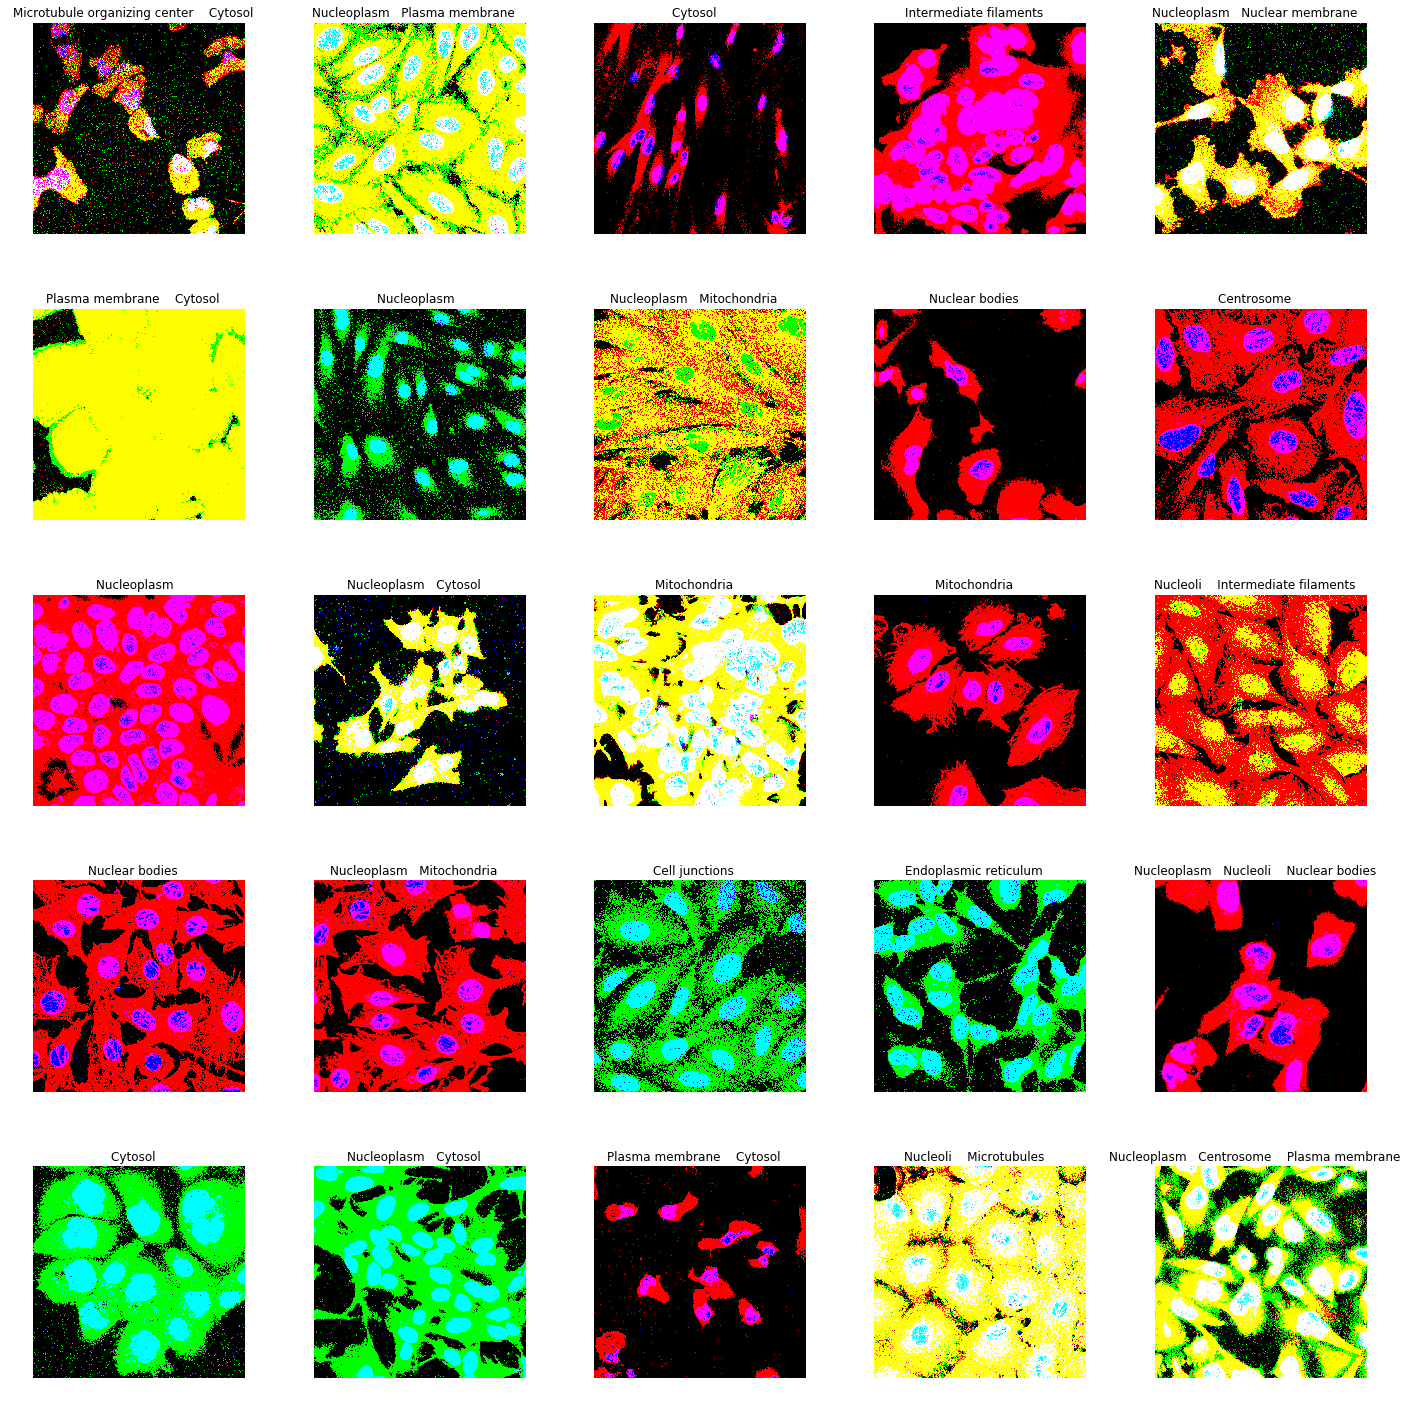

In [38]:
data.show_batch()

# Load A Model

In [39]:
# Taken From:
# https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [41]:
f1_score = partial(fbeta, thresh=0.3, beta=1)
acc = partial(accuracy_thresh, thresh=0.3)
metrics = [acc, f1_score]
loss_function = FocalLoss()

In [42]:
def save_model(model, approaches, arch, im_size, frozen, epochs):
    """
    Appropriately names and saves the model according to the paramaters
    """
    if isinstance(approaches, list):
        approaches = '-'.join(approaches)
    arch = str(arch)
    im_size = str(im_size)
    if isinstance(frozen, int):
        frozen = 'FreezeTo' + str(frozen)
    else:
        frozen = str(frozen)
    epochs = str(epochs)
    save_str = '_'.join([approaches, arch, im_size, frozen, epochs])
    model.save(save_str)
    print('Model Saved As :', save_str)
    
def load_model(model, approaches, arch, im_size, frozen, epochs):
    """
    Appropriately loads the model according to the given parameters
    """
    if isinstance(approaches, list):
        approaches = '-'.join(approaches)
    arch = str(arch)
    im_size = str(im_size)
    if isinstance(frozen, int):
        frozen = 'FreezeTo' + str(frozen)
    else:
        frozen = str(frozen)
    epochs = str(epochs)
    save_str = '_'.join([approaches, arch, im_size, frozen, epochs])
    model.load(save_str)
    print('Model Loaded from :', save_str)

In [43]:
MODEL_PATH = 'Models_Stratified'

# Tells fastai where to form the layer groups
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [46]:
resnet34 = Resnet(50, 4)

In [47]:
model = create_cnn(data, 
                   resnet34,
                   cut=-2,
                   split_on=_resnet_split, 
                   loss_func=loss_function,
                   path=PATH,
                   metrics=metrics,
                   model_dir=MODEL_PATH,
                   callback_fns = [ShowGraph]
                  )

In [48]:
load_model(model, ['stratified', 'focalLoss'], 'resnet50', 512, 'Frozen', 3)

Model Loaded from : stratified-focalLoss_resnet50_512_Frozen_3


# Heatmap Time

In [103]:
m = model.model.eval();

In [104]:
idx = np.random.randint(0, len(data.valid_ds))
x, y = data.valid_ds[idx]

In [105]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [106]:
from fastai.callbacks.hooks import *

In [107]:
def hooked_backward(cat=y):
    cat = np.argwhere(cat.data).reshape(-1)
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat[0])].backward()
    return hook_a,hook_g

In [108]:
hook_a,hook_g = hooked_backward()

In [109]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 16, 16])

In [110]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([16, 16])

In [111]:
def show_heatmap(hm):
    _,ax = plt.subplots(1,2, figsize=(15,30))
    xb_im.show(ax[0])
    ax[1].imshow(hm, alpha=0.9, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


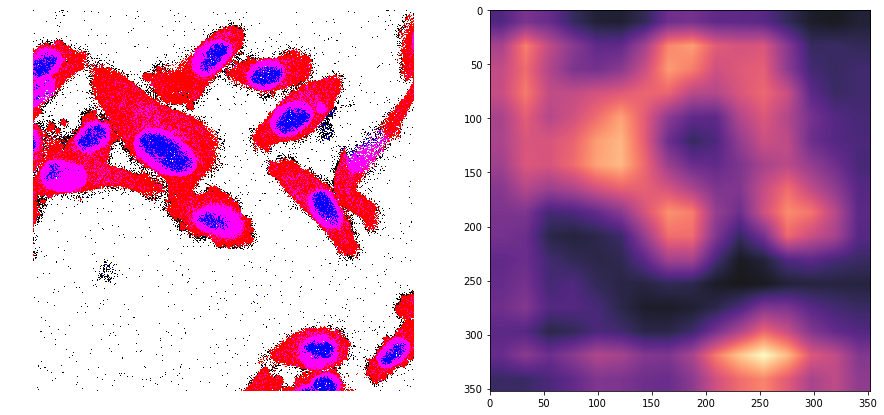

In [112]:
show_heatmap(avg_acts)